<a href="https://colab.research.google.com/github/Avanishdubey1707/ML-and-DL-project/blob/main/Cancer_Cell_detection_using_DL_(Brain_Tumour).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cancer Cell detection using DL (Brain Tumour)

In [1]:
import zipfile


In [2]:
# Collecting the data set

from google.colab import files
import os
files.upload()
!pip install -q kaggle

!mkdir -p ~/.kaggle
!mv "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

!unzip -q brain-tumor-mri-dataset.zip -d brain_tumor_data


Saving kaggle (1).json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 85% 126M/149M [00:00<00:00, 1.31GB/s]
100% 149M/149M [00:00<00:00, 1.23GB/s]


In [3]:
!pip install tensorflow

In [4]:
# importing the dependencies
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
import glob
import os
import tensorflow as tf




In [5]:
# count the number of images in the respective classes 0- brain tumour and 1- healthy

ROOT_DIR = "/content/brain_tumor_data"
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()


dict_items([('Training', 4), ('Testing', 4)])

Model Build

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

# Paths
dataset_dir = '/content/brain_tumor_data/Training'  # original dataset
test_dir = '/content/brain_tumor_data/Testing'      # separate test set

# Image size for MobileNetV2
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# -------------------------
# 1. Data Generators with validation split
# -------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of training data used for validation
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test generator (kept completely separate, only for evaluation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# -------------------------
# 2. Load MobileNetV2 base model
# -------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base layers initially

# -------------------------
# 3. Add custom layers
# -------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# -------------------------
# 4. Compile model
# -------------------------
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------------
# 5. Callbacks
# -------------------------
checkpoint = ModelCheckpoint(
    'best_mobilenetv2.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# -------------------------
# 7. Save final model
# -------------------------
model.save('brain_tumor_mobilenetv2_final.keras')
print("Model saved as brain_tumor_mobilenetv2_final.keras")



Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.4716 - loss: 1.2550
Epoch 1: val_accuracy improved from -inf to 0.68536, saving model to best_mobilenetv2.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 116s 686ms/step - accuracy: 0.4725 - loss: 1.2531 - val_accuracy: 0.6854 - val_loss: 0.8912 - learning_rate: 1.0000e-04
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7604 - loss: 0.6351
Epoch 2: val_accuracy improved from 0.68536 to 0.72217, saving model to best_mobilenetv2.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 486ms/step - accuracy: 0.7605 - loss: 0.6348 - val_accuracy: 0.7222 - val_loss: 0.7837 - learning_rate: 1.0000e-04
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7994 - loss: 0.5218
Epoch 3: val_accuracy improved from 0.72217 to 0.74934, saving model to best_mobilenetv2.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.7994 - loss: 0.5217 - val_accuracy: 0.7493 - val_loss: 0.7069 - learning_rate: 1.0000e-04
Epoch 4/1

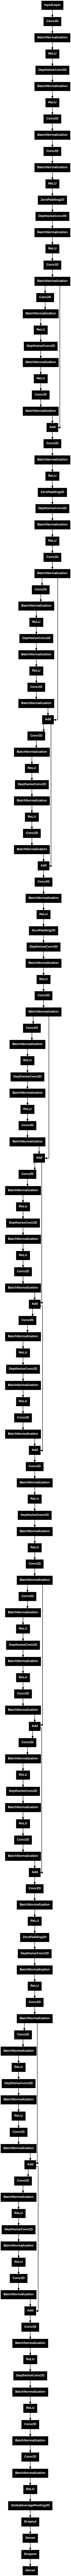

In [8]:
# model graphical representation
from tensorflow.keras.utils import plot_model
plot_model(model)

In [11]:
# Model accuracy
from keras.models import load_model
model = load_model("/content/best_mobilenetv2.keras")

In [13]:
acc = model.evaluate(test_generator)[1]
print(f"The Accuracy of the model is = { acc*100} %")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - accuracy: 0.7441 - loss: 0.6645
The Accuracy of the model is = 82.22730755805969 %


In [14]:
from tensorflow.keras.utils import load_img, img_to_array


In [15]:
path="/content/brain_tumor_data/Testing/notumor/Te-noTr_0001.jpg"
img=tf.keras.utils.load_img(path, target_size=(224,224))
input_arr=tf.keras.utils.img_to_array(img)
input_arr=np.array([input_arr]) / 255.0  # normalize if model trained on rescaled images
pred = model.predict(input_arr)

# Define your class labels
class_labels = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Get predicted class and confidence
predicted_class_index = np.argmax(pred)
predicted_class_name = class_labels[predicted_class_index]
confidence = pred[0][predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Confidence: {confidence:.4f}")

# Print all class probabilities
print("\nClass Probabilities:")
for i, prob in enumerate(pred[0]):
    print(f"{class_labels[i]}: {prob:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted Class: notumor
Confidence: 0.9958

Class Probabilities:
glioma: 0.0002
meningioma: 0.0023
notumor: 0.9958
pituitary: 0.0018


In [17]:
from sklearn.metrics import classification_report

# Get predictions on the test set
test_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(test_labels, predicted_classes, target_names=list(test_generator.class_indices.keys()))
print(report)

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step
              precision    recall  f1-score   support

      glioma       0.93      0.76      0.84       300
  meningioma       0.74      0.54      0.62       306
     notumor       0.90      0.96      0.92       405
   pituitary       0.72      1.00      0.84       300

    accuracy                           0.82      1311
   macro avg       0.82      0.81      0.81      1311
weighted avg       0.83      0.82      0.81      1311



In [21]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Choose an image from your dataset, for example from the test set
# Replace this with the actual path to the image you want to check
image_path = "/content/brain_tumor_data/Testing/glioma/Te-glTr_0000.jpg"

# Load and resize the image
img = load_img(image_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = img_to_array(img)

# Expand dimensions to match the input shape of the model (add batch dimension)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (rescale pixel values)
# Make sure this matches the preprocessing used during training
img_array /= 255.0

# Make a prediction
predictions = model.predict(img_array)

# Get the predicted class index and probability
predicted_class_index = np.argmax(predictions)
confidence = predictions[0][predicted_class_index]

# Get the class labels from the test generator
class_labels = list(test_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Set a confidence threshold
confidence_threshold = 0.8

print(f"Analyzing image: {image_path}")

if confidence >= confidence_threshold:
    print(f"The model is confident that the image is a {predicted_class_name.upper()}")
    print(f"Confidence: {confidence:.4f}")
else:
    print(f"The model is not highly confident about the prediction.")
    print(f"Predicted Class: {predicted_class_name}")
    print(f"Confidence: {confidence:.4f}")

# You can also print the probabilities for all classes
print("\nClass Probabilities:")
for i, prob in enumerate(predictions[0]):
    print(f"{class_labels[i]}: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Analyzing image: /content/brain_tumor_data/Testing/glioma/Te-glTr_0000.jpg
The model is confident that the image is a GLIOMA
Confidence: 0.9880

Class Probabilities:
glioma: 0.9880
meningioma: 0.0090
notumor: 0.0006
pituitary: 0.0023
